In [1]:
import proplot as pplt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import glob

In [2]:
data_hist_ssp245_MPI_ESM  = '/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/MergeDataOut/tas_Amon_1850-2022_*.nc'
# #data_hist_CanESM5 = '/pool/data/CMIP6/data/CMIP/CCCma/CanESM5/historical/tas_*.nc'
# #data_hist_GFDL    = '/pool/data/CMIP6/data/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp245/r1i1p1f1/Amon/tas/gn/v20190710/tas_*.nc'
# #data_ssp370 = '/pool/data/CMIP6/data/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp370/r1i1p1f1/Amon/tas/gn/v20190710/tas_*.nc'
# #data_ssp585 = '/pool/data/CMIP6/data/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp585/r1i1p1f1/Amon/tas/gn/v20190710/tas_*.nc'
# import glob
# myfiles = glob.glob(data_hist_MPI_ESM)
# file_list = sorted(myfiles)
# file_list

In [3]:
# for i in range(len(file_list)):
#     ds = xr.open_dataset(file_list[i])
#     ds = ds.assign_coords({'run': i+1})
#     ds.to_netcdf('/work/mh0033/m301036/LSAT/Merged-CMIP6/tas_hist_MPI-ESM1-1-LR_run'+str(i+1)+'_185001-201412_rg.nc')

In [4]:
# ds = xr.open_mfdataset(data_hist_ssp245_MPI_ESM ,combine = 'nested', concat_dim = 'run')
ds = xr.open_mfdataset(data_hist_ssp245_MPI_ESM, combine = 'nested', concat_dim = 'run')
ds
# ds['tas'].to_netcdf('/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/tas_hist_ssp245_1850-2022_30run.nc')
# tas = ds['tas'].loc['1850-01-01':'2022-12-01',0:90,:]
# tas.shape

<xarray.Dataset>
Dimensions:    (time: 2076, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 2076, 2), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 2076, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.3 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.3 (https://mpi...

In [5]:
#Perfrom land sea mask
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)
# land_sea_mask.coords

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

In [6]:
mask_data = land_sea_mask['var1']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=ds['time'], method='nearest')

# Apply the land-sea mask to the original dataset
masked_tas = ds.where(mask_data == 1, drop=False)

# # Broadcast the mask to match the shape of the original dataset's time dimension
# broadcasted_mask = xr.broadcast(mask_data, ds['time'])[0]

# # Apply the land-sea mask to the original dataset
# masked_tas = xr.where(broadcasted_mask == 1, ds, np.nan).fillna(np.nan)

# Print the resulting masked dataset
masked_tas

<xarray.Dataset>
Dimensions:    (run: 30, time: 2076, bnds: 2, lat: 90, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds, lat, lon) datetime64[ns] dask.array<chunksize=(1, 2076, 2, 90, 180), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 2076, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.3 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.3 (https://mpi...

In [7]:
tas = masked_tas['tas'].loc[:,'1900-01-01':'2022-12-31',0:90,:]
tas = tas - 273.15
print(tas.min().values)
tas_climatology = tas.groupby('time.month').mean(dim='time')
tas_climatology
tas_ano = tas.groupby('time.month') - tas_climatology
tas_ano
print(tas_ano.min().values)

-53.34633


/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 123 times more chunks
  return self.array[key]


-23.067959


In [8]:
#calculate the annual mean of the spatial pattern
lat = tas_ano['lat']
lon = tas_ano['lon']
# tas_ano_annual_latlon = tas_ano.resample(time='1Y').mean()
# tas_ano_annual_latlon

In [9]:
# tas_annual_ano_latlon = tas_ano_annual_latlon.mean(dim='time')
# tas_annual_ano_latlon, tas_annual_ano_latlon.min().values, tas_annual_ano_latlon.max().values

In [10]:
#Separate data into monthly and output as new nc file
time_data = tas_ano['time']
time_index = pd.to_datetime(time_data.values)
time_index

DatetimeIndex(['1900-01-16 12:00:00', '1900-02-15 00:00:00',
               '1900-03-16 12:00:00', '1900-04-16 00:00:00',
               '1900-05-16 12:00:00', '1900-06-16 00:00:00',
               '1900-07-16 12:00:00', '1900-08-16 12:00:00',
               '1900-09-16 00:00:00', '1900-10-16 12:00:00',
               ...
               '2022-03-16 12:00:00', '2022-04-16 00:00:00',
               '2022-05-16 12:00:00', '2022-06-16 00:00:00',
               '2022-07-16 12:00:00', '2022-08-16 12:00:00',
               '2022-09-16 00:00:00', '2022-10-16 12:00:00',
               '2022-11-16 00:00:00', '2022-12-16 12:00:00'],
              dtype='datetime64[ns]', length=1476, freq=None)

In [11]:
# for month in time_index.month.unique():
#     month_data = tas_ano.sel(time=time_index.month==month)
#     output_file_path= f"/work/mh0033/m301036/LSAT/Merged-CMIP6/tas_hist_{month}.nc"
#     month_data.to_netcdf(output_file_path)

In [12]:
weights = np.cos(np.deg2rad(tas.lat))*xr.ones_like(tas['lon'])

In [13]:
#calculate the annual mean of the SAT
# weights = np.cos(np.deg2rad(tas_ano.lat))
# weights.name = "weights"
# weights

tas_ano_weighted = tas_ano.weighted(weights)
# display(tas_ano_weighted)
tas_ano_weighted_mean = tas_ano_weighted.mean(dim=['lat','lon'])
tas_ano_weighted_mean

<xarray.DataArray 'tas' (run: 30, time: 1476)>
dask.array<truediv, shape=(30, 1476), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2022-12-16T12:00:00
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: run

In [14]:
tas_ano_annual = tas_ano_weighted_mean.groupby('time.year').mean('time')
tas_ano_annual
# display(tas_ano_annual.min().values)
tas_ano_annual.max().values


array(1.72148467)

In [15]:
seasons = ['JJA', 'DJF']
season_means = {}

for season in seasons:
    if season == 'JJA':
        months = [6,7,8]
    elif season == 'DJF':
        months =[12,1,2]
    
    season_months = tas_ano.sel(time=tas.time.dt.month.isin(months),lat=slice(0,90))
    
    # Calculate the seasonal mean SAT anomalies
    season_mean_anomalies = (season_months * weights).mean(dim=['lat', 'lon']) / weights.mean(dim=['lat', 'lon'])
    
    # Store the seasonal mean in the dictionary
    season_means[season] = season_mean_anomalies

# Access the multiyear JJA mean SAT anomalies
    
JJA_tas = season_means['JJA']
DJF_tas = season_means['DJF']

JJA_tas

<xarray.DataArray (run: 30, time: 369)>
dask.array<truediv, shape=(30, 369), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-06-16 ... 2022-08-16T12:00:00
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 6 7 8 6 7 8 6 7 8 6 7 8 6 ... 6 7 8 6 7 8 6 7 8 6 7 8
Dimensions without coordinates: run

In [16]:
DJF_tas_mean = DJF_tas.groupby('time.year').mean(dim='time')
DJF_tas_mean

<xarray.DataArray (run: 30, year: 123)>
dask.array<transpose, shape=(30, 123), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

In [17]:
JJA_tas_mean = JJA_tas.groupby('time.year').mean(dim='time')
JJA_tas_mean[0,:].values

array([-6.05499102e-01, -5.27888498e-01, -3.85945007e-01, -1.36111468e+00,
       -6.92205388e-01, -2.11841262e-01, -8.14224961e-01, -6.51237077e-01,
       -3.66946005e-01, -8.62550708e-01, -4.52153570e-01, -1.10033977e-01,
       -7.27949563e-01, -6.63913906e-01, -3.93890277e-01, -2.74554417e-01,
       -5.25545716e-01, -5.64548341e-01, -6.07768663e-01, -4.66471995e-01,
       -2.41395686e-01, -2.38140040e-01, -3.19456516e-01, -2.56694159e-01,
       -1.51144858e-01, -4.93141030e-01, -5.40937285e-01, -2.04327520e-01,
       -1.10620526e-01, -2.82163090e-01, -2.82677761e-01, -8.00301270e-02,
       -3.47833897e-01, -4.10257290e-01, -6.74629471e-01, -3.38973413e-01,
       -2.98492866e-01, -4.85636251e-01, -3.11399052e-01, -3.90533169e-01,
       -8.33472415e-02, -2.85282159e-01, -1.43212131e-01,  9.38594966e-02,
       -3.79795229e-01, -5.57383489e-01, -2.02878769e-01,  1.92244442e-01,
       -1.49715879e-01, -3.00827506e-01, -2.71043287e-01,  2.52639441e-02,
       -2.32194226e-02,  

In [18]:
#output 30 run annual mean SAT
# tas_ano_annual_np = tas_ano_annual['tas'].values
x = np.arange(1900,2023,1)
num_time_series = tas_ano_annual.shape[0]

# tas_ano_annual_var = tas_ano_annual['tas']
# tas_ano_JJA_var = tas_ano_JJA['tas']
# tas_ano_DJF_var = tas_ano_DJF['tas']
# tas_ano_JJA_var
len(x)

123

In [19]:
#insert the observational annual mean SAT and JJA DJF mean SAT
dir_input = '/work/mh0033/m301036/LSAT/Data/Regrid/'

data_CRUTEMP  = dir_input+'tas_CRUTEMP_regrid.nc'
data_MLOST    = dir_input+'tas_MLOST_regrid.nc'
data_GISSTEMP = dir_input+'tas_GISS_regrid.nc'

#Using dateTime to select key period
tas_GISS    = xr.open_dataset(data_GISSTEMP)
tas_CRUTEMP = xr.open_dataset(data_CRUTEMP) 
tas_MLOST   = xr.open_dataset(data_MLOST,decode_times=False)
units, reference_data = tas_MLOST.time.attrs['units'].split('since')
# display(tas_MLOST.time)

tas_CRUTEMP = tas_CRUTEMP.roll(lon=len(tas_CRUTEMP.lon)//2, roll_coords=True)
tas_CRUTEMP['lon'] = np.where(tas_CRUTEMP['lon']> 180, tas_CRUTEMP['lon']-360, tas_CRUTEMP['lon'])
print(tas_CRUTEMP)

tas_MLOST = tas_MLOST.roll(lon=len(tas_MLOST.lon)//2, roll_coords=True)
tas_MLOST['lon'] = np.where(tas_MLOST['lon']> 180, tas_MLOST['lon']-360, tas_MLOST['lon'])
tas_MLOST

# tas_CRUTEMP = tas_CRUTEMP.astype(np.float64)
# tas_CRUTEMP = tas_CRUTEMP-273.15
# # tas_GHCNv4  = tas_GHCNv4-273.15
# # tas_MLOST_sel = tas_MLOST_sel-273.15
# display(tas_CRUTEMP)

<xarray.Dataset>
Dimensions:    (time: 2078, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2023-02-15
  * lon        (lon) float64 180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    tas        (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.7
    institution:  Climatic Research Unit, University of East Anglia/Met Offic...
    comment:      CRUTEM5 air temperature at 2m
    history:      Wed May 24 15:21:38 2023: cdo remapbil,r180x90 /work/mh0033...
    licence:      CRUTEM5 is licensed under the Open Government Licence v3.0 ...
    reference:    Osborn, T. J., P. D. Jones, D. H. Lister, C. P. Morice, I. ...
    source:      

<xarray.Dataset>
Dimensions:    (time: 2079, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) float64 1.826e+04 1.829e+04 ... 8.148e+04 8.151e+04
  * lon        (lon) float64 180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 ...
    air        (time, lat, lon) float32 -0.1569 -0.1569 -0.1418 ... 5.342 5.45
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.0.6 (https://mpim...
    Conventions:           CF-1.0
    source:                https://www.ncdc.noaa.gov/noaa-merged-land-ocean-g...
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    ...                    ...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Wed May 24 15:21:45 2023: cdo remapbil,r180x90 /wo...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18
    CDO:                   Climate Data Operators version 2.0.6 (https://mpim...

In [20]:
tas_MLOST_recon = pd.to_datetime(tas_MLOST.time.data, unit='D', origin=pd.Timestamp('1800-01-01'))
tas_MLOST_recon

DatetimeIndex(['1850-01-01', '1850-02-01', '1850-03-01', '1850-04-01',
               '1850-05-01', '1850-06-01', '1850-07-01', '1850-08-01',
               '1850-09-01', '1850-10-01',
               ...
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01'],
              dtype='datetime64[ns]', length=2079, freq=None)

In [21]:
tas_MLOST = tas_MLOST['air'].assign_coords({"time":(tas_MLOST_recon)})
tas_MLOST

<xarray.DataArray 'air' (time: 2079, lat: 90, lon: 180)>
array([[[-0.15694359, -0.15688585, -0.141769  , ..., -0.16739571,
         -0.16737254, -0.15700108],
        [-0.1649962 , -0.15870577, -0.15028718, ..., -0.17661345,
         -0.17446819, -0.17128664],
        [-0.1764684 , -0.16776879, -0.16040087, ..., -0.19667207,
         -0.19134113, -0.18516803],
        ...,
        [-1.1115959 , -1.0352854 , -0.9638754 , ..., -1.2638357 ,
         -1.2313491 , -1.1879065 ],
        [-0.88033426, -0.83896834, -0.798267  , ..., -0.9828353 ,
         -0.9538104 , -0.92170024],
        [-0.8194093 , -0.81908476, -0.7427386 , ..., -0.89479893,
         -0.8944996 , -0.81973374]],

       [[-0.15694359, -0.15688585, -0.141769  , ..., -0.16739571,
         -0.16737254, -0.15700108],
        [-0.1649962 , -0.15870577, -0.15028718, ..., -0.17661345,
         -0.17446819, -0.17128664],
        [-0.1764684 , -0.16776879, -0.16040087, ..., -0.19667207,
         -0.19134113, -0.18516803],
...
        [ 7.156488  ,  7.1382604 ,  7.131872  , ...,  7.0929813 ,
          7.1422906 ,  7.1747155 ],
        [ 7.675711  ,  7.6791778 ,  7.6898785 , ...,  7.6236663 ,
          7.65093   ,  7.6722445 ],
        [ 7.8025594 ,  7.802716  ,  7.849944  , ...,  7.766648  ,
          7.7667956 ,  7.802403  ]],

       [[ 2.772532  ,  2.7725055 ,  2.7568634 , ...,  2.7858758 ,
          2.785799  ,  2.772559  ],
        [ 2.8339708 ,  2.8262098 ,  2.8177824 , ...,  2.8144631 ,
          2.8311539 ,  2.8417318 ],
        [ 3.102466  ,  3.0657928 ,  3.0223746 , ...,  2.9425554 ,
          3.0601282 ,  3.1391394 ],
        ...,
        [ 5.877064  ,  5.9312196 ,  5.992216  , ...,  5.662142  ,
          5.746272  ,  5.822909  ],
        [ 5.5359607 ,  5.58287   ,  5.6299057 , ...,  5.38696   ,
          5.4385962 ,  5.489051  ],
        [ 5.4503827 ,  5.4508367 ,  5.5559964 , ...,  5.3418584 ,
          5.3423066 ,  5.4499288 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
  * lon      (lon) float64 180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Attributes:
    standard_name:          air_temperature_anomaly
    long_name:              Surface Air Temperature and SST Monthly Anomaly
    units:                  degC
    var_desc:               Air Temperature
    level_desc:             Surface
    statistic:              Anomaly
    parent_stat:            Observation
    precision:              2
    cell_methods:           time: anomaly (monthly from values)
    dataset:                NOAA Global Temperature
    date_of_file_acquired:  2020-5-4
    actual_range:           [-20.1062  25.29  ]

In [22]:
# Apply the land-sea mask to the original dataset
# Align the time coordinates between the mask dataset and the original dataset
mask_data_obs = land_sea_mask['var1']
mask_data_obs
# Align the time coordinates between the mask dataset and the original dataset
time_values1= pd.to_datetime(mask_data_obs['time'].values, format='mixed', dayfirst=True)
mask_data_obs['time'] = time_values1
mask_data_obs = mask_data_obs.reindex(time=tas_MLOST['time'], method='nearest')

masked_MLOST_tas = tas_MLOST.where(mask_data_obs == 1, drop=False)

# Print the resulting masked dataset
masked_MLOST_tas

<xarray.DataArray 'air' (time: 2079, lat: 90, lon: 91)>
array([[[-0.15694359, -0.17261031, -0.1726103 , ..., -0.16739571,
         -0.16737254, -0.15700108],
        [-0.1649962 , -0.18251109, -0.18251109, ..., -0.17661345,
         -0.17446819, -0.17128664],
        [-0.1764684 , -0.2221142 , -0.2221142 , ..., -0.19667207,
         -0.19134113, -0.18516803],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.15694359, -0.17261031, -0.1726103 , ..., -0.16739571,
         -0.16737254, -0.15700108],
        [-0.1649962 , -0.18251109, -0.18251109, ..., -0.17661345,
         -0.17446819, -0.17128664],
        [-0.1764684 , -0.2221142 , -0.2221142 , ..., -0.19667207,
         -0.19134113, -0.18516803],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 2.772532  ,  2.1166353 ,  2.1152482 , ...,  2.7858758 ,
          2.785799  ,  2.772559  ],
        [ 2.8339708 ,  1.5726835 ,  0.51334757, ...,  2.8144631 ,
          2.8311539 ,  2.8417318 ],
        [ 3.102466  ,  2.1357586 ,  1.4998415 , ...,  2.9425554 ,
          3.0601282 ,  3.1391394 ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
  * lon      (lon) float64 180.0 0.0 2.0 4.0 6.0 ... 172.0 174.0 176.0 178.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Attributes:
    standard_name:          air_temperature_anomaly
    long_name:              Surface Air Temperature and SST Monthly Anomaly
    units:                  degC
    var_desc:               Air Temperature
    level_desc:             Surface
    statistic:              Anomaly
    parent_stat:            Observation
    precision:              2
    cell_methods:           time: anomaly (monthly from values)
    dataset:                NOAA Global Temperature
    date_of_file_acquired:  2020-5-4
    actual_range:           [-20.1062  25.29  ]

In [23]:
# tas_GISS_annual    = tas_GISS['air'].loc['1900-01-01':'2022-12-31',0:90,:]
# #xr.DataArray.transpose(tas_GISS['lat'], transpose_coords=True, missing_dims='raise').groupby('time.year').groups
# tas_CRUTEMP_annual = tas_CRUTEMP['tas'].loc['1900-01-01':'2022-12-31',0:90,:]
# tas_MLOST_annual   = masked_MLOST_tas.loc['1900-01-01':'2022-12-31',0:90,:]

# tas_GISS_ano     = tas_GISS_annual-tas_GISS_annual.mean()
# tas_CRUTEMP_ano  = tas_CRUTEMP_annual-tas_CRUTEMP_annual.mean()
# tas_MLOST_ano    = tas_MLOST_annual-tas_MLOST_annual.mean()

# year = np.arange(1900,2022,1)
# lat = tas_CRUTEMP['lat']
# lon = tas_CRUTEMP['lon']

# # print(tas_GISS_ano)
# print(tas_MLOST_ano)

# print(tas_CRUTEMP_ano)

In [24]:
# MLOST_annual = tas_MLOST_ano.groupby('time.year').mean(dim='time')
# MLOST_annual_mean = MLOST_annual.mean(dim='year')
# MLOST_annual_mean

In [25]:
# #Calculate the annual mean anomalies
# tas_GISS_annual    = tas_GISS_ano.mean(['lat','lon']).groupby('time.year').mean()
# tas_CRUTEMP_annual = tas_CRUTEMP_ano.mean(['lat','lon']).groupby('time.year').mean()
# tas_MLOST_annual   = tas_MLOST_ano.mean(['lat','lon']).groupby('time.year').mean()

# print(tas_GISS_annual)

In [26]:
# #Calculate the summertime anomalies
# tas_GISS_JJA     = tas_GISS_ano.loc[tas_GISS_ano.time.dt.month.isin([6,7,8])]
# tas_CRUTEMP_JJA  = tas_CRUTEMP_ano.loc[tas_CRUTEMP_ano.time.dt.month.isin([6,7,8])]
# tas_MLOST_JJA    = tas_MLOST_ano.loc[tas_MLOST_ano.time.dt.month.isin([6,7,8])]

# #calculate the wintertime anomalies
# tas_GISS_DJF     = tas_GISS_ano.loc[tas_GISS_ano.time.dt.month.isin([12,1,2])].loc['1900-12-01':'2022-03-01']
# tas_CRUTEMP_DJF  = tas_CRUTEMP_ano.loc[tas_CRUTEMP_ano.time.dt.month.isin([12,1,2])].loc['1900-12-01':'2022-03-01']
# tas_MLOST_DJF    = tas_MLOST_ano.loc[tas_MLOST_ano.time.dt.month.isin([12,1,2])].loc['1900-12-01':'2022-03-01']

# tas_GISS_JJA_mean = tas_GISS_JJA.mean(['lat','lon']).groupby('time.year').mean()
# tas_CRUTEMP_JJA_mean = tas_CRUTEMP_JJA.mean(['lat','lon']).groupby('time.year').mean()
# tas_MLOST_JJA_mean = tas_MLOST_JJA.mean(['lat','lon']).groupby('time.year').mean()

# tas_GISS_DJF_mean = tas_GISS_DJF.mean(['lat','lon']).groupby('time.year').mean()
# tas_CRUTEMP_DJF_mean = tas_CRUTEMP_DJF.mean(['lat','lon']).groupby('time.year').mean()
# tas_MLOST_DJF_mean = tas_MLOST_DJF.mean(['lat','lon']).groupby('time.year').mean()
# tas_MLOST_DJF_mean.min()

In [27]:
#Input observational SAT timeseries
#Annual
CRUTEMP  = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/CRUTEM5_annual_NH.txt',delimiter='\t', skip_header=1)
CRUTEMP1 = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/CRUTEM5_JJA_NH.txt',delimiter='\t', skip_header=1)
CRUTEMP2 = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/CRUTEM5_DJF_NH.txt',delimiter='\t', skip_header=1)
tas_CRUTEMP_annual = CRUTEMP[:,1]
tas_CRUTEMP_JJA = CRUTEMP1[:,1]
tas_CRUTEMP_DJF = CRUTEMP2[:,1]

GISS = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/GISS_annual_NH.txt',delimiter='\t', skip_header=1)
GISS1 = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/GISS_JJA_NH.txt',delimiter='\t', skip_header=1)
GISS2 = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/GISS_DJF_NH.txt',delimiter='\t', skip_header=1)
tas_GISS_annual = GISS[:,1]
tas_GISS_JJA = GISS1[:,1]
tas_GISS_DJF = GISS2[:,1]

MLOST = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/MLOST_annual_NH.txt',delimiter='\t', skip_header=1)
MLOST1 = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/MLOST_JJA_NH.txt',delimiter='\t', skip_header=1)
MLOST2 = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/MLOST_DJF_NH.txt',delimiter='\t', skip_header=1)
tas_MLOST_annual = MLOST[:,1]
tas_MLOST_JJA = MLOST1[:,1]
tas_MLOST_DJF = MLOST2[:,1]

In [29]:
tas_ano_annual

<xarray.DataArray 'tas' (run: 30, year: 123)>
dask.array<transpose, shape=(30, 123), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

In [30]:
trend_mean = tas_ano_annual.mean(dim='run')
trend_JJA_mean = JJA_tas_mean.mean(dim='run')
trend_DJF_mean = DJF_tas_mean.mean(dim='run')

trend_DJF_mean.shape
trend_mean = xr.DataArray(trend_mean,dims=('year'), coords={'year': x})
trend_JJA_mean = xr.DataArray(trend_JJA_mean,dims=('year'), coords={'year': x})
trend_DJF_mean = xr.DataArray(trend_DJF_mean,dims=('year'), coords={'year': x})

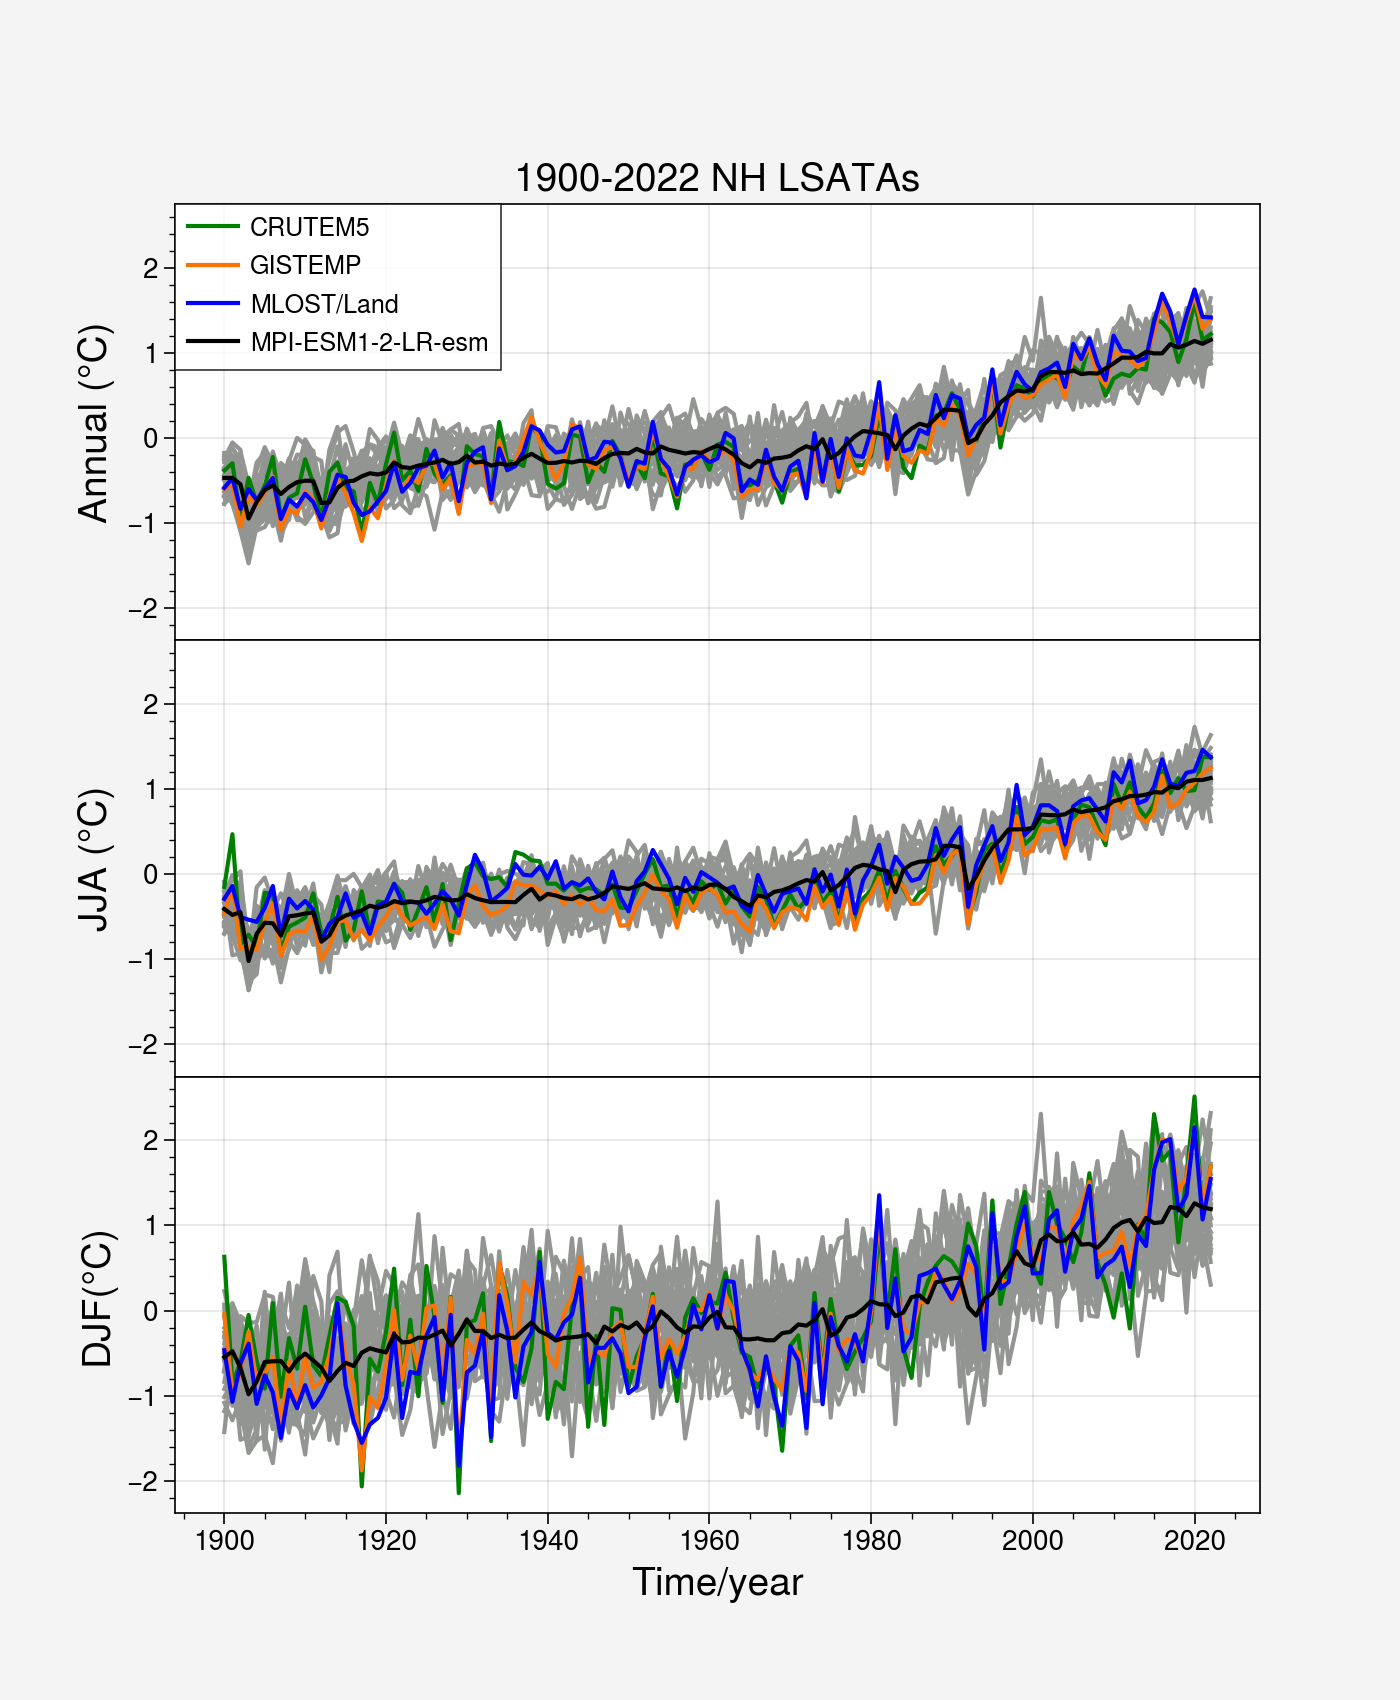

In [31]:
# import seaborn as sns
# sns.set_theme()

fig,axs = plt.subplots(3,1, figsize=(7,8.5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)
# plt.style.use('ggplot')
for i in range(num_time_series):
    axs[0].plot(x, tas_ano_annual[i, :], color='gray')
    
axs[0].plot(x, tas_CRUTEMP_annual, color='green', label='CRUTEM5')
axs[0].plot(x, tas_GISS_annual, color='orange', label='GISTEMP')
axs[0].plot(x, tas_MLOST_annual, color='blue', label='MLOST/Land')
axs[0].plot(x, trend_mean, color='black', label='MPI-ESM1-2-LR-esm')

axs[0].set_title('1900-2022 NH LSATAs',fontsize=14)
axs[0].set_ylabel('Annual (°C)', fontsize=14)
axs[0].set_xlabel('Time/year', fontsize=14)
# axs[0].grid(visible=False, which='major', axis='y')
axs[0].tick_params(axis='x', labelsize=10)
axs[0].tick_params(axis='y', labelsize=10)

# handles, labels = axs[0].get_legend_handles_labels()
# legend = axs[0].legend(handles, labels, loc='best')
# for text, handle in zip(legend.get_texts(), legend.legendHandles):
#     color=handel.get_color()
#     text.set_color(color)

axs[0].legend()
# Plot the JJA time series
for i in range(num_time_series):
    axs[1].plot(x, JJA_tas_mean[i, :], label=f"Time Series {i+1}", color='gray')

axs[1].plot(x, tas_CRUTEMP_JJA, color='green')
axs[1].plot(x, tas_GISS_JJA, color='orange')
axs[1].plot(x, tas_MLOST_JJA, color='blue')
axs[1].plot(x, trend_JJA_mean, color='black')
axs[1].set_ylabel('JJA (°C)', fontsize=14)
axs[1].set_xlabel('Time/year', fontsize=14)
# axs[1].grid(visible=False, which='major', axis='y')
axs[1].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='y', labelsize=10)

# Plot the DJF time series
for i in range(num_time_series):
    axs[2].plot(x, DJF_tas_mean[i, :], label=f"Time Series {i+1}", color='gray')
    
axs[2].plot(x, tas_CRUTEMP_DJF, color='green')
axs[2].plot(x, tas_GISS_DJF, color='orange')
axs[2].plot(x, tas_MLOST_DJF, color='blue')
axs[2].plot(x, trend_DJF_mean, color='black')

# axs[2].set_title('MPI-ESM1-LR 1850-2014 DJF SAT')
axs[2].set_ylabel('DJF(°C)', fontsize=14)
axs[2].set_xlabel('Time/year', fontsize=14)
# axs[2].grid(visible=False, which='major', axis='y')
axs[2].tick_params(axis='x', labelsize=10)
axs[2].tick_params(axis='y', labelsize=10)

plt.show()

In [32]:
fig.savefig("MPI-ESM-LR-NH_averaged_SAT_TS_1900-2022.png")

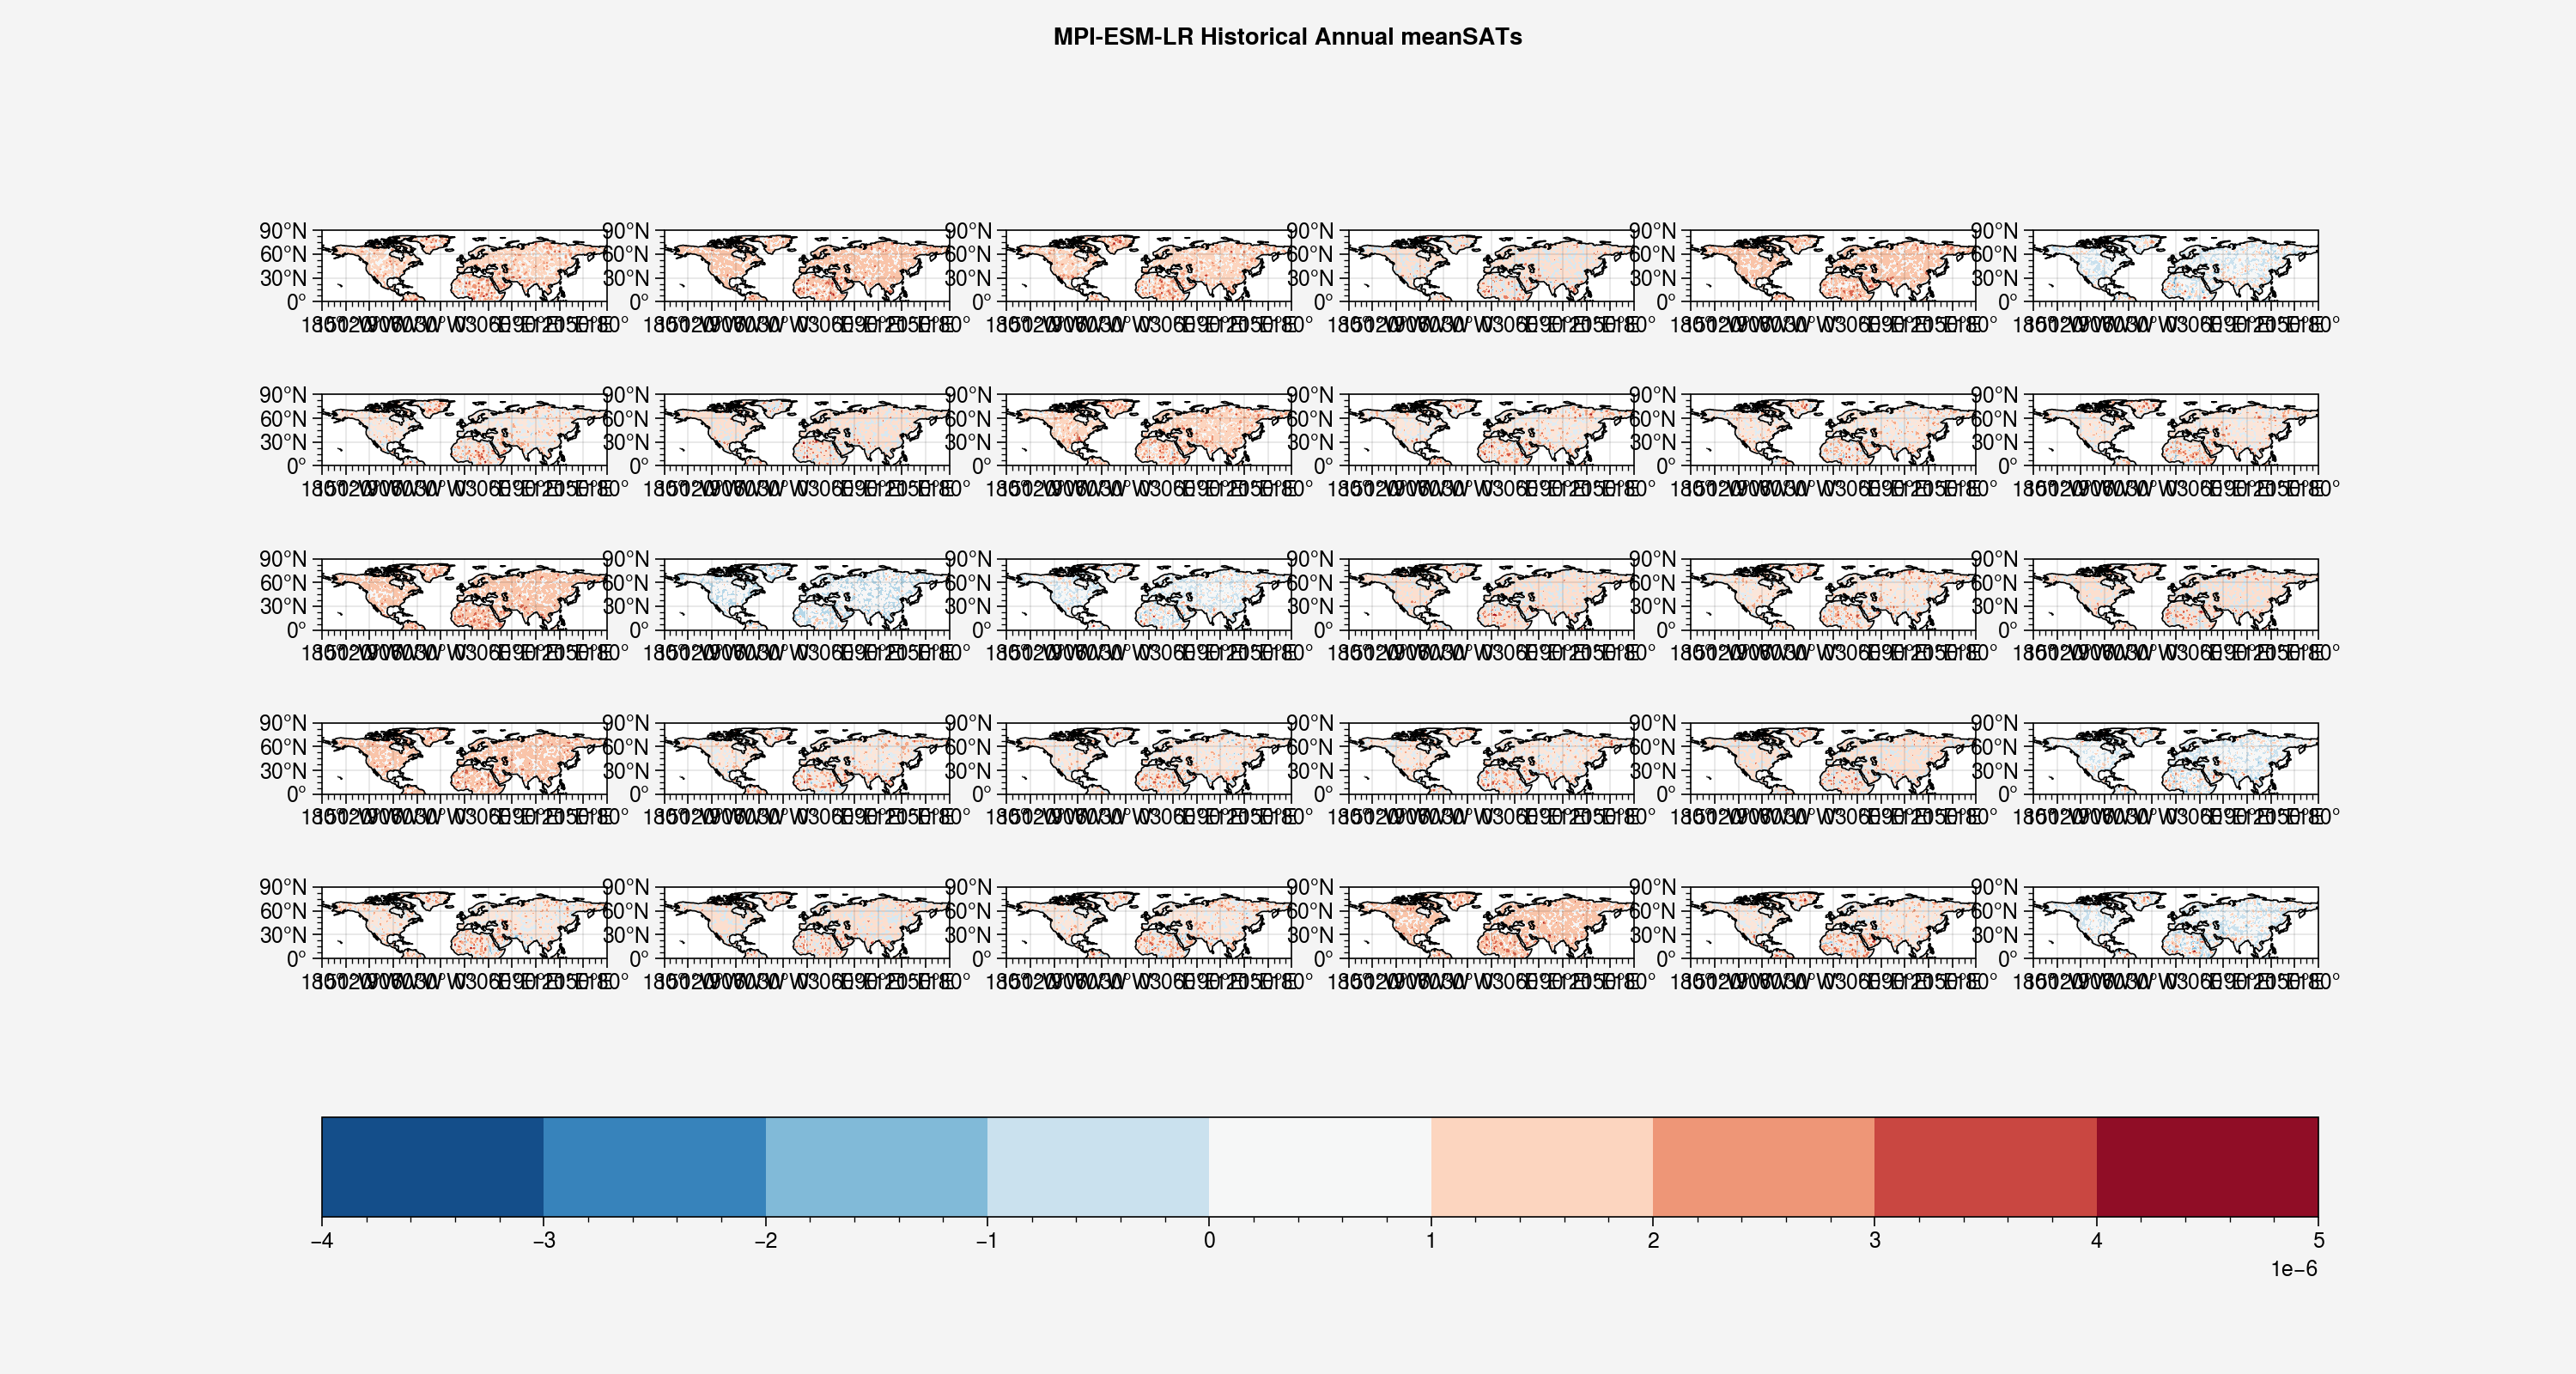

In [89]:

# import proplot as pplt
rows = 5
cols = 6

# create the figure and axes
projection = ccrs.PlateCarree()
fig, axs = plt.subplots(rows, cols, figsize=(15,8), subplot_kw={'projection':projection})
fig.suptitle('MPI-ESM-LR Historical Annual meanSATs')

# plot each model run
for i,ax in enumerate(axs.flat):
    mp=ax.contourf(lon, lat, tas_annual_ano_latlon[i, :, :], cmap='RdBu_r')#levels=np.arange(-30,30, 2.5)
    ax.set_xticks(np.arange(-180, 210, 30))#, crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(0, 120, 30))#, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
    ax.coastlines()
fig.colorbar(mp, ax=axs, orientation='horizontal', fraction=.1)
    
# add a legend and axis labels
# ax.legend()
# ax.set_xlabel('Time')
# ax.set_ylabel('Model Output')
# display the figure
plt.show()
# images = []
# for i in range(Nr):
#     for j in range(Nc):
#         # Generate data with a range that varies from one plot to the next.
#         data = tas_ano()
#         images.append(axs[i, j].imshow(data))
#         axs[i, j].label_outer()

# # Find the min and max of all colors for use in setting the color scale.
# vmin = min(image.get_array().min() for image in images)
# vmax = max(image.get_array().max() for image in images)
# norm = colors.Normalize(vmin=vmin, vmax=vmax)
# for im in images:
#     im.set_norm(norm)

/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


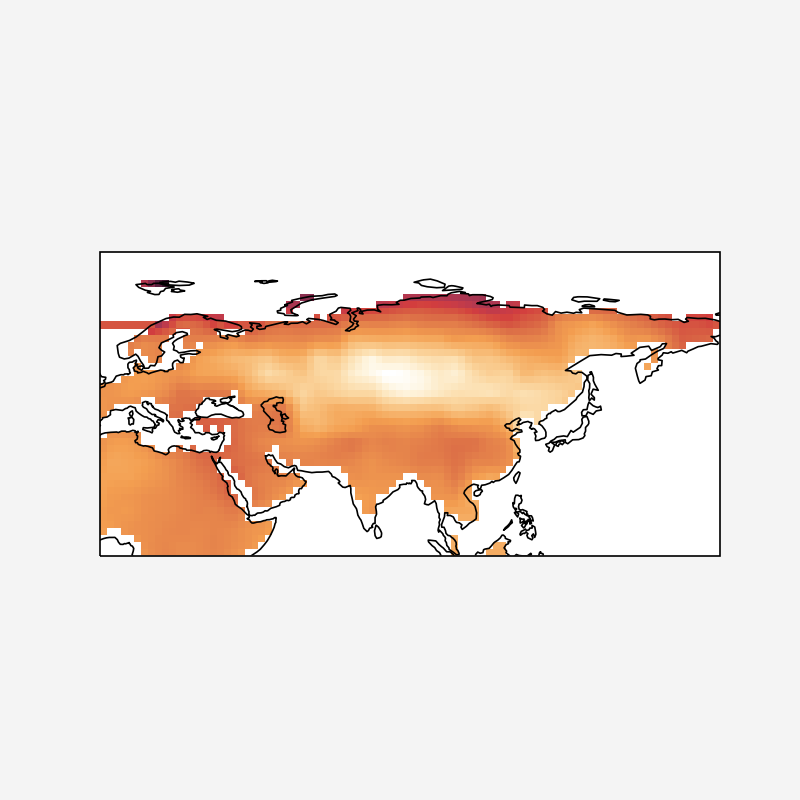

In [73]:
fig, ax = plt.subplots(subplot_kw={'projection': projection})
ax.pcolormesh(MLOST_annual_mean['lon'], MLOST_annual_mean['lat'], MLOST_annual_mean, transform=ccrs.PlateCarree())
ax.coastlines()

plt.show()